# Index Differences Between Fields
This notebook looks at how papers have different pageranks between fields

In [1]:
import glob
import itertools
import pickle as pkl
import sys
from functools import lru_cache

import numpy as np
import pandas as pd
import plotly.express as px
from plotnine import *
from tqdm import tqdm

sys.path.append('../indices')
from utils import parse_metadata

In [2]:
def calculate_percentiles(true_vals, doi_to_shuffled_metrics):
    dois, pageranks = [], []
    for doi, pagerank in true_vals.items():
        if pagerank is not None:
            dois.append(doi)
            pageranks.append(pagerank)
            
    percentiles = []
    for doi in dois:
        shuffled_metrics = doi_to_shuffled_metrics[doi]
        # If the node is unshuffleable for some reason, its percentile isn't meaningful
        if len(set(shuffled_metrics)) == 1:
            percentiles.append(None)
            continue
        true_val = true_vals[doi]
    
        percentile = np.searchsorted(shuffled_metrics, true_val) / 100
        percentiles.append(percentile)

    result_df = pd.DataFrame({'doi': dois, 'pagerank': pageranks, 'percentile': percentiles})
    return result_df

In [3]:
#@lru_cache(2)
def load_single_heading(heading_str):
    heading_shuffled = glob.glob(f'../output/shuffle_results/{heading_str}*-pagerank.pkl')

    doi_to_shuffled_metrics = {}

    for path in heading_shuffled:
        with open(path, 'rb') as in_file:
            result = pkl.load(in_file)
            for doi, value in result.items():
                if doi in doi_to_shuffled_metrics:
                    doi_to_shuffled_metrics[doi].append(value)
                else:
                    doi_to_shuffled_metrics[doi] = [value]
    for doi, vals in doi_to_shuffled_metrics.items():
        doi_to_shuffled_metrics[doi] = sorted(vals)
    
    with open(f'../output/{heading_str}-pagerank.pkl', 'rb') as in_file:
        true_vals = pkl.load(in_file)
        
    heading_df = calculate_percentiles(true_vals, doi_to_shuffled_metrics)
    return heading_df

def load_pair_headings(heading1, heading2):
    heading1_df = load_single_heading(f'{heading1}-{heading2}')
    heading2_df = load_single_heading(f'{heading2}-{heading1}')

    merged_df = heading1_df.merge(heading2_df, on='doi')
    merged_df = merged_df.rename({'pagerank_x': f'{heading1}_pagerank', 'pagerank_y': f'{heading2}_pagerank',
                                  'percentile_x': f'{heading1}_percentile', 'percentile_y': f'{heading2}_percentile'}, 
                                 axis='columns')
    merged_df[f'{heading1}-{heading2}'] = merged_df[f'{heading1}_percentile'] - merged_df[f'{heading2}_percentile']
    
    metadata_df = parse_metadata(f'../data/pubmed/efetch/{heading1}.xml.xz')
    full_df = merged_df.merge(metadata_df, on='doi')
    
    return full_df

In [4]:
load_single_heading('computational_biology-medical_informatics')

,doi,pagerank,percentile
0,10.1021/pr800161x,0.000006,0.12
1,10.1371/journal.pone.0192452,0.000002,0.68
2,10.1371/journal.pone.0183495,0.000002,1.00
3,10.1016/j.jbiotec.2012.05.008,0.000002,1.00
4,10.1007/978-1-4939-3759-2_21,0.000002,1.00
...,...,...,...
196489,10.1093/bioinformatics/btq599,0.000003,0.36
196490,10.1038/ng.3652,0.000002,0.71
196491,10.1016/j.ecoenv.2021.112345,0.000002,1.00
196492,10.1186/1471-2105-15-7,0.000007,0.11


## Load AI results

In [5]:
ai_shuffled = glob.glob('../output/shuffle_results/artificial_intelligence_*-pagerank.pkl')

doi_to_shuffled_metrics = {}

for path in ai_shuffled:
    with open(path, 'rb') as in_file:
        result = pkl.load(in_file)
        for doi, value in result.items():
            if doi in doi_to_shuffled_metrics:
                doi_to_shuffled_metrics[doi].append(value)
            else:
                doi_to_shuffled_metrics[doi] = [value]
                

In [6]:
for doi, vals in doi_to_shuffled_metrics.items():
    doi_to_shuffled_metrics[doi] = sorted(vals)

In [7]:
with open('../output/artificial_intelligence-pagerank.pkl', 'rb') as in_file:
    true_vals = pkl.load(in_file)

In [8]:
ai_df = calculate_percentiles(true_vals, doi_to_shuffled_metrics)
ai_df

,doi,pagerank,percentile
0,10.1002/1097-0150(2000)5:5<326::aid-igs2>3.0.c...,0.000004,1.00
1,10.1007/bf00311745,0.000005,0.61
2,10.1016/s1072-7515(98)00105-7,0.000073,1.00
3,10.1016/s0090-4295(98)00168-x,0.000051,0.92
4,10.1016/s0741-5214(96)70272-0,0.000177,1.00
...,...,...,...
102216,10.1016/j.healthpol.2021.01.001,0.000005,1.00
102217,10.1007/s11427-011-4263-x,0.000004,1.00
102218,10.1109/tnnls.2020.2995631,0.000004,1.00
102219,10.1016/j.eururo.2019.03.038,0.000004,1.00


<AxesSubplot:>

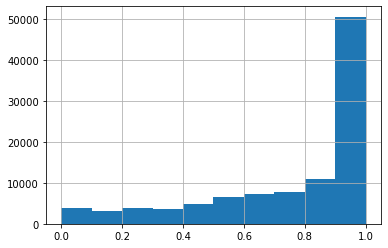

In [9]:
ai_df['percentile'].hist()

In [10]:
ai_df['percentile'].value_counts() / len(ai_df)

1.00    0.397365
0.85    0.011328
0.87    0.011172
0.91    0.011162
0.86    0.010927
          ...   
0.15    0.002857
0.14    0.002847
0.05    0.002788
0.09    0.002778
0.08    0.002759
Name: percentile, Length: 101, dtype: float64

## Load comp bio resuls

In [11]:
comp_bio_shuffled = glob.glob('../output/shuffle_results/computational_biology_*-pagerank.pkl')

doi_to_shuffled_metrics = {}

for path in comp_bio_shuffled:
    with open(path, 'rb') as in_file:
        result = pkl.load(in_file)
        for doi, value in result.items():
            if doi in doi_to_shuffled_metrics:
                doi_to_shuffled_metrics[doi].append(value)
            else:
                doi_to_shuffled_metrics[doi] = [value]
                

In [12]:
for doi, vals in doi_to_shuffled_metrics.items():
    doi_to_shuffled_metrics[doi] = sorted(vals)

In [13]:
with open('../output/computational_biology-pagerank.pkl', 'rb') as in_file:
    true_vals = pkl.load(in_file)
    
comp_bio_df = calculate_percentiles(true_vals, doi_to_shuffled_metrics)
comp_bio_df


,doi,pagerank,percentile
0,10.3945/ajcn.110.001289,0.000002,0.87
1,10.1017/s0007114508076253,0.000004,0.43
2,10.3945/ajcn.111.017921,0.000012,0.08
3,10.1007/s00439-009-0662-5,0.000038,0.82
4,10.1038/nprot.2007.511,0.000050,0.97
...,...,...,...
196489,10.1007/978-1-0716-2071-7_17,0.000001,1.00
196490,10.1093/ndt/gfab320,0.000001,1.00
196491,10.2174/1381612822666160907093215,0.000002,1.00
196492,10.3390/ijerph19042392,0.000001,1.00


<AxesSubplot:>

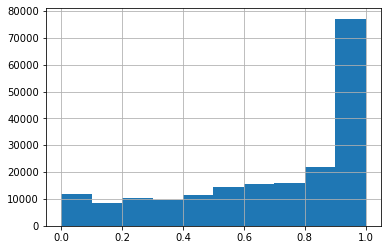

In [14]:
comp_bio_df['percentile'].hist()

## Load Genetics results

In [15]:
genetics_shuffled = glob.glob('../output/shuffle_results/genetics_*-pagerank.pkl')

doi_to_shuffled_metrics = {}

for path in genetics_shuffled:
    with open(path, 'rb') as in_file:
        result = pkl.load(in_file)
        for doi, value in result.items():
            if doi in doi_to_shuffled_metrics:
                doi_to_shuffled_metrics[doi].append(value)
            else:
                doi_to_shuffled_metrics[doi] = [value]
                

In [16]:
for doi, vals in doi_to_shuffled_metrics.items():
    doi_to_shuffled_metrics[doi] = sorted(vals)

In [17]:
with open('../output/genetics-pagerank.pkl', 'rb') as in_file:
    true_vals = pkl.load(in_file)
    
genetics_df = calculate_percentiles(true_vals, doi_to_shuffled_metrics)
genetics_df


,doi,pagerank,percentile
0,10.1002/1097-0142(20010815)92:4<932::aid-cncr1...,0.000008,0.08
1,10.1056/nejm199705153362002,0.000167,0.99
2,10.1056/nejm199605023341812,0.000067,1.00
3,10.1002/(sici)1096-8628(20000228)90:5<361::aid...,0.000026,0.60
4,10.1002/1097-0177(2000)9999:9999<::aid-dvdy103...,0.000004,0.51
...,...,...,...
208501,10.4014/jmb.1403.03032,0.000002,1.00
208502,10.1007/978-1-0716-2071-7_17,0.000002,1.00
208503,10.1002/ana.26293,0.000002,1.00
208504,10.1002/pmic.202100232,0.000002,1.00


<AxesSubplot:>

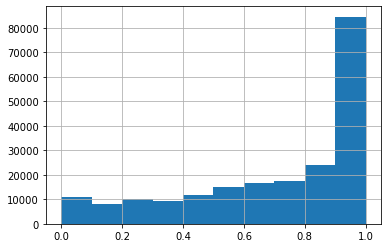

In [18]:
genetics_df['percentile'].hist()

## Merge ai and comp bio and plot results

In [19]:
merged_df = comp_bio_df.merge(ai_df, on='doi')
merged_df = merged_df.rename({'pagerank_x': 'comp_bio_pagerank', 'pagerank_y': 'ai_pagerank',
                              'percentile_x': 'comp_bio_percentile', 'percentile_y': 'ai_percentile'}, 
                             axis='columns')
merged_df['cb-ai'] = merged_df['comp_bio_percentile'] - merged_df['ai_percentile']

merged_df

,doi,comp_bio_pagerank,comp_bio_percentile,ai_pagerank,ai_percentile,cb-ai
0,10.1016/s0169-409x(02)00011-x,0.000026,0.76,0.000029,0.92,-0.16
1,10.1146/annurev-nutr-072610-145159,0.000022,0.04,0.000009,1.00,-0.96
2,10.1093/nar/gkr988,0.000292,0.05,0.000590,1.00,-0.95
3,10.3945/ajcn.116.135301,0.000008,0.01,0.000005,1.00,-0.99
4,10.1101/gr.1239303,0.002035,0.74,0.002337,0.84,-0.10
...,...,...,...,...,...,...
8811,10.1515/bmc-2022-0001,0.000001,1.00,0.000004,1.00,0.00
8812,10.1155/2022/5334095,0.000001,1.00,0.000004,1.00,0.00
8813,10.1093/nar/gkab1025,0.000001,1.00,0.000004,1.00,0.00
8814,10.1182/blood.2021013054,0.000001,1.00,0.000004,1.00,0.00


In [ ]:
fig = px.scatter(merged_df, x='comp_bio_pagerank', y='ai_pagerank', log_x=True, log_y=True, 
                 opacity=.3, color='comp_bio_percentile', title='Comp bio percentiles')
fig.show()

In [ ]:
fig = px.scatter(merged_df, x='comp_bio_pagerank', y='ai_pagerank', log_x=True, log_y=True, 
                 opacity=.3, color='ai_percentile', title='ai percentiles')
fig.show()

In [ ]:
fig = px.scatter(merged_df, x='comp_bio_pagerank', y='ai_pagerank', log_x=True, log_y=True, 
                 opacity=.5, color='cb-ai', color_continuous_scale='RdBu', hover_data=['doi'],
                 title='Relative importance of papers in comp bio and ai')
fig.show()

In [23]:
# Get papers that did surprisingly well in comp bio but surprisingly poorly in ai
merged_df.sort_values(by='cb-ai', ascending=False).head(5)

,doi,comp_bio_pagerank,comp_bio_percentile,ai_pagerank,ai_percentile,cb-ai
7556,10.1016/j.cmpb.2017.12.016,0.000002,1.0,0.000010,0.00,1.00
8644,10.1016/j.compbiomed.2020.103805,0.000002,1.0,0.000019,0.01,0.99
8014,10.1016/j.compbiomed.2020.103795,0.000002,1.0,0.000024,0.01,0.99
8078,10.1016/j.compbiomed.2020.103792,0.000002,1.0,0.000089,0.01,0.99
6784,10.1016/j.cmpb.2016.02.004,0.000003,1.0,0.000013,0.02,0.98


In [24]:
merged_df.sort_values(by='cb-ai', ascending=True).head(5)

,doi,comp_bio_pagerank,comp_bio_percentile,ai_pagerank,ai_percentile,cb-ai
2924,10.1093/bioinformatics/btz207,0.000003,0.0,0.000004,1.0,-1.0
856,10.1074/mcp.m112.017509,0.000008,0.0,0.000004,1.0,-1.0
892,10.1038/ncomms2814,0.000004,0.0,0.000009,1.0,-1.0
350,10.1093/nar/gkt1140,0.000051,0.0,0.000266,1.0,-1.0
2248,10.1016/j.aca.2015.02.068,0.000006,0.0,0.000004,1.0,-1.0


Papers that did very well in CB and very poorly in ai include:
- "Symtosis: A liver ultrasound tissue characterization and risk stratification in optimized deep learning paradigm"
- "Automated detection of COVID-19 cases using deep neural networks with X-ray images"
- "COVID-19 detection using deep learning models to exploit Social Mimic Optimization and structured chest X-ray images using fuzzy color and stacking approache"
- "Application of deep learning technique to manage COVID-19 in routine clinical practice using CT images: Results of 10 convolutional neural networks"
- "PCA-based polling strategy in machine learning framework for coronary artery disease risk assessment in intravascular ultrasound: A link between carotid and coronary grayscale plaque morphology"

Papers that did well in AI but poorly in CB:
- "Activities at the Universal Protein Resource (UniProt)"
- "Lipidomic data analysis: Tutorial, practical guidelines and applications"
- "A Novel Method for the Simultaneous Enrichment, Identification, and Quantification of Phosphopeptides and Sialylated Glycopeptides Applied to a Temporal Profile of Mouse Brain Development*"
- "Peptide Fingerprinting of Alzheimer's Disease in Cerebrospinal Fluid: Identification and Prospective Evaluation of New Synaptic Biomarkers"
- "CliqueMS: a computational tool for annotating in-source metabolite ions from LC-MS untargeted metabolomics data based on a coelution similarity network "


## Merge genetics and comp bio and plot results

In [25]:
merged_df = comp_bio_df.merge(genetics_df, on='doi')
merged_df = merged_df.rename({'pagerank_x': 'comp_bio_pagerank', 'pagerank_y': 'genetics_pagerank',
                              'percentile_x': 'comp_bio_percentile', 'percentile_y': 'genetics_percentile'}, 
                             axis='columns')
merged_df['cb-genetics'] = merged_df['comp_bio_percentile'] - merged_df['genetics_percentile']

merged_df

,doi,comp_bio_pagerank,comp_bio_percentile,genetics_pagerank,genetics_percentile,cb-genetics
0,10.3945/ajcn.110.001289,0.000002,0.87,0.000002,0.85,0.02
1,10.1017/s0007114508076253,0.000004,0.43,0.000003,0.49,-0.06
2,10.1007/s00439-009-0662-5,0.000038,0.82,0.000005,0.83,-0.01
3,10.1016/j.meatsci.2009.08.028,0.000017,0.70,0.000004,0.70,0.00
4,10.3945/ajcn.111.022657,0.000005,0.34,0.000006,0.52,-0.18
...,...,...,...,...,...,...
112003,10.1128/aem.01743-21,0.000001,1.00,0.000002,1.00,0.00
112004,10.1007/s00705-022-05390-1,0.000001,1.00,0.000002,1.00,0.00
112005,10.1631/jzus.b1900070,0.000002,1.00,0.000002,0.93,0.07
112006,10.1007/978-1-0716-2071-7_17,0.000001,1.00,0.000002,1.00,0.00


In [ ]:
fig = px.scatter(merged_df, x='comp_bio_pagerank', y='genetics_pagerank', log_x=True, log_y=True, 
                 opacity=.3, color='comp_bio_percentile', title='Comp bio percentiles')
fig.show()

In [ ]:
fig = px.scatter(merged_df, x='comp_bio_pagerank', y='genetics_pagerank', log_x=True, log_y=True, 
                 opacity=.3, color='genetics_percentile', title='Genetics percentiles')
fig.show()

In [ ]:
fig = px.scatter(merged_df, x='comp_bio_pagerank', y='genetics_pagerank', log_x=True, log_y=True, 
                 opacity=.5, color='cb-genetics', color_continuous_scale='RdBu', hover_data=['doi'],
                 title='Relative importance of papers in comp bio and genetics')
fig.show()

In [29]:
# Get papers that did surprisingly well in comp bio but surprisingly poorly in genetics
merged_df.sort_values(by='cb-genetics', ascending=False).head(5)

,doi,comp_bio_pagerank,comp_bio_percentile,genetics_pagerank,genetics_percentile,cb-genetics
31835,10.1073/pnas.0903045106,0.000021,1.00,0.000015,0.00,1.00
58256,10.1098/rsob.140071,0.000001,1.00,0.000002,0.01,0.99
12366,10.1080/07357900601063873,0.000030,0.99,0.000005,0.00,0.99
31785,10.1111/j.1365-294x.2006.03197.x,0.000002,0.98,0.000007,0.00,0.98
11971,10.1101/gr.093955.109,0.000122,0.99,0.000012,0.02,0.97


In [30]:
merged_df.sort_values(by='cb-genetics', ascending=True).head(5)

,doi,comp_bio_pagerank,comp_bio_percentile,genetics_pagerank,genetics_percentile,cb-genetics
47175,10.1093/bioinformatics/bty039,0.000004,0.00,0.000002,1.0,-1.00
28064,10.1038/s41467-019-11994-0,0.000005,0.00,0.000002,1.0,-1.00
23601,10.1093/bioinformatics/btq465,0.000006,0.01,0.000042,1.0,-0.99
29121,10.1093/bioinformatics/btw564,0.000003,0.02,0.000002,1.0,-0.98
32127,10.1371/journal.pone.0200283,0.000003,0.05,0.000002,1.0,-0.95


Papers that did very well in CB and very poorly in genetics include:
- "Analysis of genomic diversity in Mexican Mestizo populations to develop genomic medicine in Mexico" 
- "Deciphering next-generation pharmacogenomics: an information technology perspective
- "A Serum Proteomic Pattern for the Detection of Colorectal Adenocarcinoma Using Surface Enhanced Laser Desorption and Ionization Mass Spectrometry
- "Mechanisms of population differentiation in seabirds"
- "Quantitative phenotyping via deep barcode sequencing

Papers that did well in genetics but not in CB:
- "Deep learning extends de novo protein modelling coverage of genomes using iteratively predicted structural constraints"
- "O-GlcNAcPRED-II: an integrated classification algorithm for identifying O-GlcNAcylation sites based on fuzzy undersampling and a K-means PCA oversampling technique"
- "DRIMM-Synteny: decomposing genomes into evolutionary conserved segments"
- "PseKRAAC: a flexible web server for generating pseudo K-tuple reduced amino acids composition"
- "GPSuc: Global Prediction of Generic and Species-specific Succinylation Sites by aggregating multiple sequence features"

## Merge ai and genetics and plot results

In [31]:
merged_df = genetics_df.merge(ai_df, on='doi')
merged_df = merged_df.rename({'pagerank_x': 'genetics_pagerank', 'pagerank_y': 'ai_pagerank',
                              'percentile_x': 'genetics_percentile', 'percentile_y': 'ai_percentile'}, 
                             axis='columns')
merged_df['genetics-ai'] = merged_df['genetics_percentile'] - merged_df['ai_percentile']

merged_df

,doi,genetics_pagerank,genetics_percentile,ai_pagerank,ai_percentile,genetics-ai
0,10.1021/tx000158x,0.000042,0.98,0.000031,0.97,0.01
1,10.4049/jimmunol.1601667,0.000003,0.90,0.000004,1.00,-0.10
2,10.1093/nar/gkw377,0.000075,0.00,0.000225,0.31,-0.31
3,10.1093/nar/gku1056,0.000008,0.18,0.000031,0.98,-0.80
4,10.1002/ar.20871,0.000007,0.35,0.000010,0.52,-0.17
...,...,...,...,...,...,...
7704,10.1515/bmc-2022-0001,0.000002,1.00,0.000004,1.00,0.00
7705,10.1186/s41065-021-00215-8,0.000002,1.00,0.000004,1.00,0.00
7706,10.1093/nar/gkab1025,0.000002,1.00,0.000004,1.00,0.00
7707,10.1182/blood.2021013054,0.000002,1.00,0.000004,1.00,0.00


In [ ]:
fig = px.scatter(merged_df, x='genetics_pagerank', y='ai_pagerank', log_x=True, log_y=True, 
                 opacity=.3, color='genetics_percentile', title='Comp bio percentiles')
fig.show()

In [ ]:
fig = px.scatter(merged_df, x='genetics_pagerank', y='ai_pagerank', log_x=True, log_y=True, 
                 opacity=.3, color='ai_percentile', title='ai percentiles')
fig.show()

In [ ]:
fig = px.scatter(merged_df, x='genetics_pagerank', y='ai_pagerank', log_x=True, log_y=True, 
                 opacity=.5, color='genetics-ai', color_continuous_scale='RdBu', hover_data=['doi'],
                 title='Relative importance of papers in genetics and ai')
fig.show()

In [35]:
# Get papers that did surprisingly well in comp bio but surprisingly poorly in ai
merged_df.sort_values(by='genetics-ai', ascending=False).head(5)

,doi,genetics_pagerank,genetics_percentile,ai_pagerank,ai_percentile,genetics-ai
17,10.4155/fmc-2016-0197,0.000002,1.00,0.000012,0.00,1.00
5185,10.1093/bioinformatics/bty039,0.000002,1.00,0.000011,0.01,0.99
1507,10.1039/c6mb00471g,0.000002,1.00,0.000008,0.03,0.97
6470,10.1016/j.cmpb.2016.02.006,0.000002,1.00,0.000006,0.04,0.96
2126,10.1186/1471-2105-13-s11-s4,0.000003,0.99,0.000012,0.03,0.96


In [36]:
merged_df.sort_values(by='genetics-ai', ascending=True).head(5)

,doi,genetics_pagerank,genetics_percentile,ai_pagerank,ai_percentile,genetics-ai
571,10.1074/mcp.m112.017509,0.000009,0.0,0.000004,1.0,-1.0
2494,10.1111/mec.13211,0.000003,0.0,0.000004,1.0,-1.0
505,10.1111/j.1365-294x.2010.04657.x,0.000017,0.0,0.000008,1.0,-1.0
2401,10.1021/acs.jproteome.7b00685,0.000002,0.0,0.000004,1.0,-1.0
1013,10.1093/molbev/msu264,0.000005,0.0,0.000005,1.0,-1.0


Papers that did very well in Genetics and very poorly in ai include:
- "Active learning for computational chemogenomics"
- "O-GlcNAcPRED-II: an integrated classification algorithm for identifying O-GlcNAcylation sites based on fuzzy undersampling and a K-means PCA oversampling technique"
- "Identifying RNA 5-methylcytosine sites via pseudo nucleotide compositions"
- "AOD: the antioxidant protein database"
- "University of Turku in the BioNLP'11 Shared Task"

Papers that did well in AI but poorly in genetics:
- "The genomics of selection in dogs and the parallel evolution between dogs and humans"
- "Population genomic evidence for adaptive differentiation in Baltic Sea three-spined sticklebacks"
- "A Novel Method for the Simultaneous Enrichment, Identification, and Quantification of Phosphopeptides and Sialylated Glycopeptides Applied to a Temporal Profile of Mouse Brain Development*"
- "Use of resistance surfaces for landscape genetic studies: considerations for parameterization and analysis
- "Adaptations to Climate-Mediated Selective Pressures in Sheep "


## Merged results
### Comp bio vs Genetics

In [37]:
merged_df = load_pair_headings('computational_biology', 'genetics')

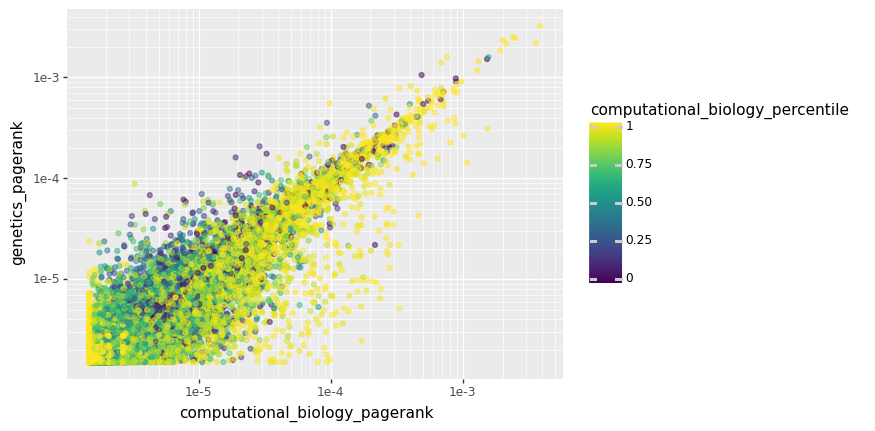

<ggplot: (8740129645385)>

In [38]:
plot = ggplot(merged_df, aes(x='computational_biology_pagerank', y='genetics_pagerank', color='computational_biology_percentile'))
plot += geom_point(alpha=.5)
plot += scale_y_log10()
plot += scale_x_log10()
plot

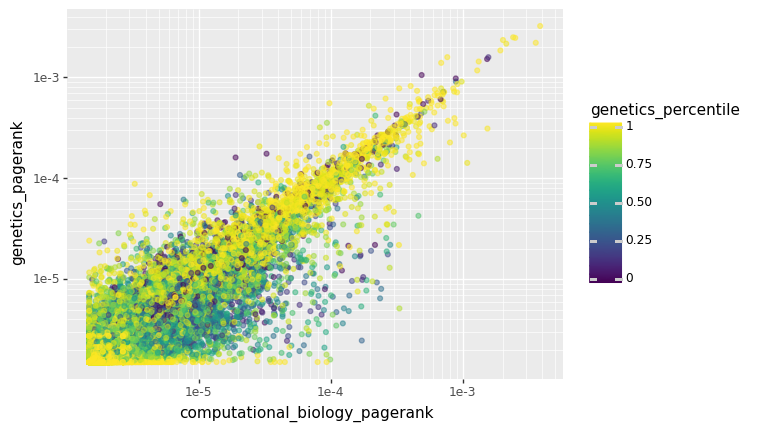

<ggplot: (8740129547769)>

In [39]:
plot = ggplot(merged_df, aes(x='computational_biology_pagerank', y='genetics_pagerank', color='genetics_percentile',))
plot += geom_point(alpha=.5)
plot += scale_y_log10()
plot += scale_x_log10()
plot

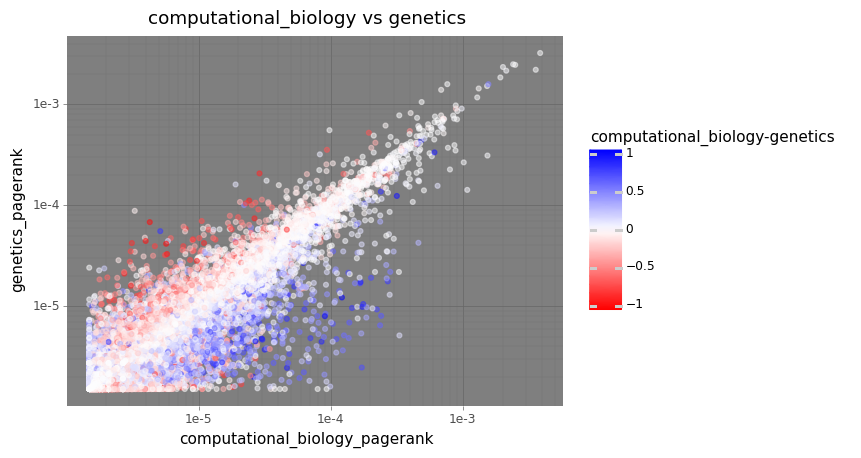

<ggplot: (8740090209470)>

In [40]:
plot = ggplot(merged_df, aes(x='computational_biology_pagerank', y='genetics_pagerank', color='computational_biology-genetics'))
plot += geom_point(alpha=.5)
plot += scale_y_log10()
plot += scale_x_log10()
plot += scale_color_gradient2(low='red', mid='white', high='blue')
plot += theme_dark()
plot += ggtitle('computational_biology vs genetics')
plot

In [41]:
# Get papers that did surprisingly well in comp bio but surprisingly poorly in genetics
merged_df.sort_values(by='computational_biology-genetics', ascending=False).head(5)

,doi,computational_biology_pagerank,computational_biology_percentile,genetics_pagerank,genetics_percentile,computational_biology-genetics,pmid,pmcid,journal,journal_nlm_id,title,publication_date,authors
4928,10.1073/pnas.0903045106,0.000021,1.0,0.000015,0.00,1.00,19433783,PMC2680428,Proc Natl Acad Sci U S A,7505876,Analysis of genomic diversity in Mexican Mesti...,2009-05-11,"[{'fore_name': 'Irma', 'last_name': 'Silva-Zol..."
27910,10.1126/science.aan6877,0.000007,1.0,0.000006,0.01,0.99,29371463,None,Science,0404511,The nature of nurture: Effects of parental gen...,2018-01-26,"[{'fore_name': 'Augustine', 'last_name': 'Kong..."
11844,10.1098/rsob.140071,0.000001,1.0,0.000002,0.01,0.99,25030607,PMC4118603,Open Biol,101580419,Deciphering next-generation pharmacogenomics: ...,2014-07,"[{'fore_name': 'George', 'last_name': 'Potamia..."
12977,10.1101/gr.093955.109,0.000122,1.0,0.000012,0.03,0.97,19622793,PMC2765281,Genome Res,9518021,Quantitative phenotyping via deep barcode sequ...,2009-07-21,"[{'fore_name': 'Andrew M', 'last_name': 'Smith..."
36390,10.1007/s00251-012-0629-x,0.000002,1.0,0.000005,0.04,0.96,22752190,PMC3438391,Immunogenetics,0420404,Killer cell immunoglobulin-like receptor (KIR)...,2012-07-01,"[{'fore_name': 'Jill A', 'last_name': 'Hollenb..."


In [42]:
merged_df.sort_values(by='computational_biology-genetics', ascending=True).head(5)

,doi,computational_biology_pagerank,computational_biology_percentile,genetics_pagerank,genetics_percentile,computational_biology-genetics,pmid,pmcid,journal,journal_nlm_id,title,publication_date,authors
30670,10.1093/bioinformatics/btw564,0.000003,0.00,0.000002,1.00,-1.00,27565583,None,Bioinformatics,9808944,PseKRAAC: a flexible web server for generating...,2016-08-26,"[{'fore_name': 'Yongchun', 'last_name': 'Zuo',..."
49038,10.1093/bioinformatics/bty039,0.000004,0.01,0.000002,1.00,-0.99,29420699,None,Bioinformatics,9808944,O-GlcNAcPRED-II: an integrated classification ...,2018-06-15,"[{'fore_name': 'Cangzhi', 'last_name': 'Jia', ..."
29592,10.1038/s41467-019-11994-0,0.000005,0.02,0.000002,1.00,-0.98,31484923,PMC6726615,Nat Commun,101528555,Deep learning extends de novo protein modellin...,2019-09-04,"[{'fore_name': 'Joe G', 'last_name': 'Greener'..."
33822,10.1371/journal.pone.0200283,0.000003,0.02,0.000002,1.00,-0.98,30312302,PMC6193575,PLoS One,101285081,GPSuc: Global Prediction of Generic and Specie...,2018-10-12,"[{'fore_name': 'Md Mehedi', 'last_name': 'Hasa..."
762,10.1016/j.jprot.2014.03.025,0.000008,0.00,0.000002,0.96,-0.96,24698665,None,J Proteomics,101475056,Metabolic fingerprint of Gestational Diabetes ...,2014-03-31,"[{'fore_name': 'Danuta', 'last_name': 'Dudzik'..."


### High CB-genetics:
- Nonlinear Data Alignment for UPLC−MS and HPLC−MS Based Metabolomics:  Quantitative Analysis of Endogenous and Exogenous Metabolites in Human Serum
- Plant metabolomics: from holistic hope, to hype, to hot topic
- Engineered gene circuits
- Genetics Meets Metabolomics: A Genome-Wide Association Study of Metabolite Profiles in Human Serum
- Metabonomics Techniques and Applications to Pharmaceutical Research & Development

### Low CB - genetics:
- PhylOTU: A High-Throughput Procedure Quantifies Microbial Community Diversity and Resolves Novel Taxa from Metagenomic Data
- Functional metagenomic profiling of nine biomes
- A human gut microbial gene catalogue established by metagenomic sequencing
- Phymm and PhymmBL: metagenomic phylogenetic classification with interpolated Markov models
- The Plant Ontology as a Tool for Comparative Plant Anatomy and Genomic Analyses 

### Comp bio vs AI

In [43]:
merged_df = load_pair_headings('computational_biology', 'artificial_intelligence')

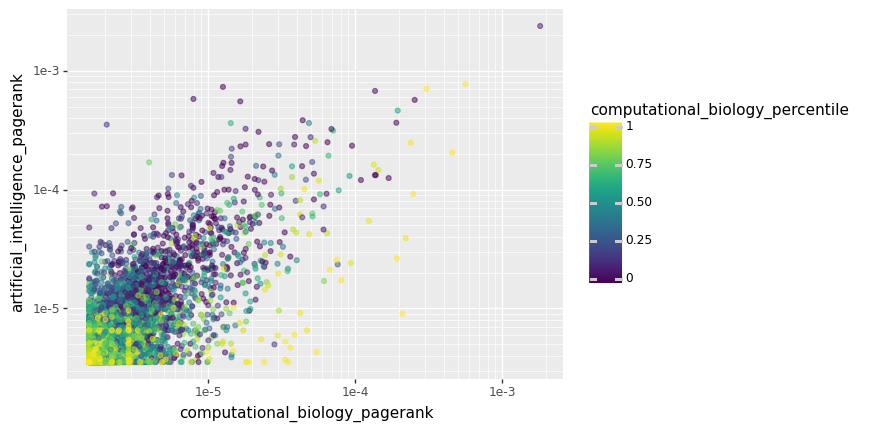

<ggplot: (8740084080025)>

In [44]:
plot = ggplot(merged_df, aes(x='computational_biology_pagerank', y='artificial_intelligence_pagerank', color='computational_biology_percentile'))
plot += geom_point(alpha=.5)
plot += scale_y_log10()
plot += scale_x_log10()
plot

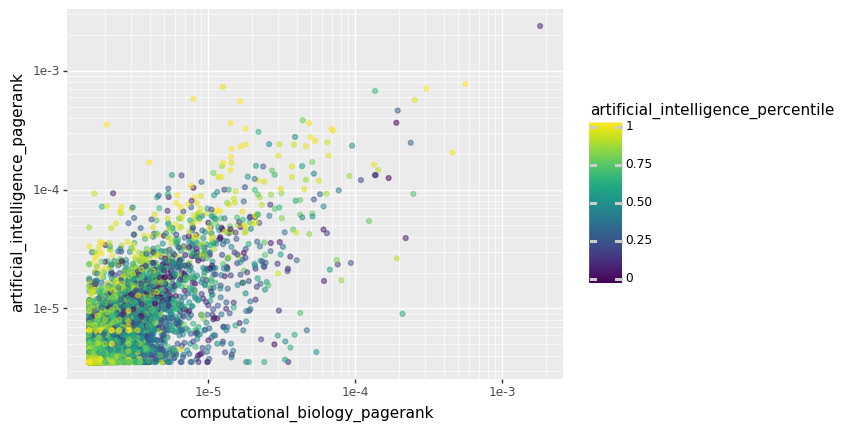

<ggplot: (8740077865669)>

In [45]:
plot = ggplot(merged_df, aes(x='computational_biology_pagerank', y='artificial_intelligence_pagerank', color='artificial_intelligence_percentile',))
plot += geom_point(alpha=.5)
plot += scale_y_log10()
plot += scale_x_log10()
plot

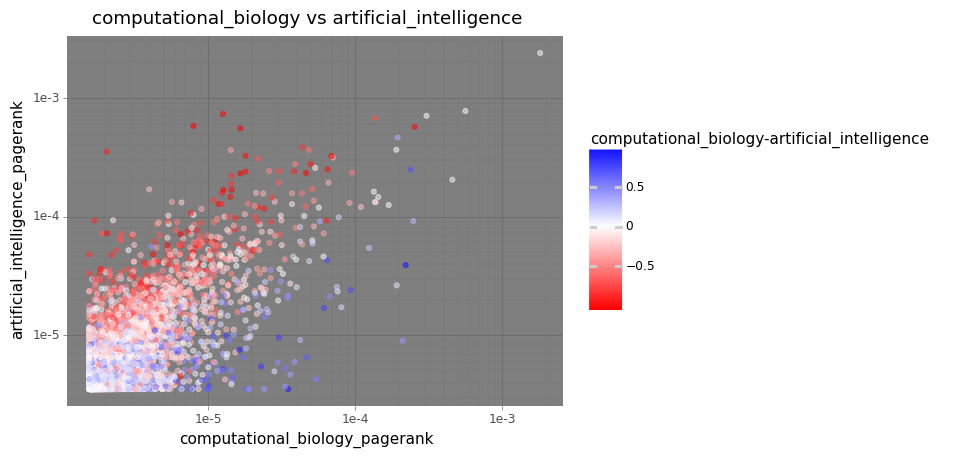

<ggplot: (8740076799571)>

In [46]:
plot = ggplot(merged_df, aes(x='computational_biology_pagerank', y='artificial_intelligence_pagerank', color='computational_biology-artificial_intelligence'))
plot += geom_point(alpha=.5)
plot += scale_y_log10()
plot += scale_x_log10()
plot += scale_color_gradient2(low='red', mid='white', high='blue')
plot += theme_dark()
plot += ggtitle('computational_biology vs artificial_intelligence')
plot

In [47]:
# Get papers that did surprisingly well in comp bio but surprisingly poorly in artificial_intelligence
merged_df.sort_values(by='computational_biology-artificial_intelligence', ascending=False).head(5)

,doi,computational_biology_pagerank,computational_biology_percentile,artificial_intelligence_pagerank,artificial_intelligence_percentile,computational_biology-artificial_intelligence,pmid,pmcid,journal,journal_nlm_id,title,publication_date,authors
332,10.1186/1471-2105-6-31,0.000221,0.97,0.000039,0.06,0.91,15713233,PMC553969,BMC Bioinformatics,100965194,Automated generation of heuristics for biologi...,2005-02-15,"[{'fore_name': 'Guy St C', 'last_name': 'Slate..."
2700,10.1016/s0076-6879(99)03015-3,0.000035,0.99,0.000004,0.10,0.89,10349647,None,Methods Enzymol,0212271,Construction and analysis of arrayed cDNA libr...,1999,"[{'fore_name': 'M D', 'last_name': 'Clark', 'a..."
771,10.1002/prot.10507,0.000016,0.96,0.000008,0.11,0.85,14635133,None,Proteins,8700181,Better prediction of sub-cellular localization...,2003-12-01,"[{'fore_name': 'Rajesh', 'last_name': 'Nair', ..."
1846,10.1093/bioinformatics/bty228,0.000002,0.91,0.000011,0.10,0.81,29949978,PMC6022636,Bioinformatics,9808944,Convolutional neural networks for classificati...,2018-07-01,"[{'fore_name': 'Genta', 'last_name': 'Aoki', '..."
7684,10.1109/tbme.2018.2824725,0.000002,0.95,0.000006,0.14,0.81,29993426,PMC6342004,IEEE Trans Biomed Eng,0012737,Brain-Wide Genome-Wide Association Study for A...,2018-04-09,"[{'fore_name': 'Tao', 'last_name': 'Zhou', 'af..."


In [48]:
merged_df.sort_values(by='computational_biology-artificial_intelligence', ascending=True).head(5)

,doi,computational_biology_pagerank,computational_biology_percentile,artificial_intelligence_pagerank,artificial_intelligence_percentile,computational_biology-artificial_intelligence,pmid,pmcid,journal,journal_nlm_id,title,publication_date,authors
110,10.1006/jbin.2001.1029,0.000008,0.00,0.000580,0.99,-0.99,12123149,None,J Biomed Inform,100970413,A simple algorithm for identifying negated fin...,2001-10,"[{'fore_name': 'W W', 'last_name': 'Chapman', ..."
1020,10.1089/1066527041410382,0.000008,0.00,0.000051,0.99,-0.99,15285891,None,J Comput Biol,9433358,Physical network models.,2004,"[{'fore_name': 'Chen-Hsiang', 'last_name': 'Ye..."
1122,10.1371/journal.pcbi.1003711,0.000017,0.00,0.000231,0.99,-0.99,25033408,PMC4102394,PLoS Comput Biol,101238922,Enhanced regulatory sequence prediction using ...,2014-07-17,"[{'fore_name': 'Mahmoud', 'last_name': 'Ghandi..."
728,10.1093/bioinformatics/btu277,0.000017,0.01,0.000553,1.00,-0.99,24931975,PMC4058935,Bioinformatics,9808944,Deep learning of the tissue-regulated splicing...,2014-06-15,"[{'fore_name': 'Michael K K', 'last_name': 'Le..."
255,10.1093/bioinformatics/btl094,0.000013,0.00,0.000168,0.99,-0.99,16543277,None,Bioinformatics,9808944,Combining multi-species genomic data for micro...,2006-03-16,"[{'fore_name': 'Malik', 'last_name': 'Yousef',..."


### High CB-ai:
- Automated generation of heuristics for biological sequence comparison
- Improving accuracy of microarray classification by a simple multi-task feature selection filter
- Construction and analysis of arrayed cDNA libraries
- Better prediction of sub-cellular localization by combining evolutionary and structural information
- Brain-Wide Genome-Wide Association Study for Alzheimer's Disease via Joint Projection Learning and Sparse Regression Model

### Low CB - ai:
- A Simple Algorithm for Identifying Negated Findings and Diseases in Discharge Summaries
- Combining multi-species genomic data for microRNA identification using a Naïve Bayes classifier 
- Deep learning of the tissue-regulated splicing code 
- Activities at the Universal Protein Resource (UniProt) 
- Enhanced Regulatory Sequence Prediction Using Gapped k-mer Features

### AI vs genetics

In [49]:
merged_df = load_pair_headings('genetics', 'artificial_intelligence')

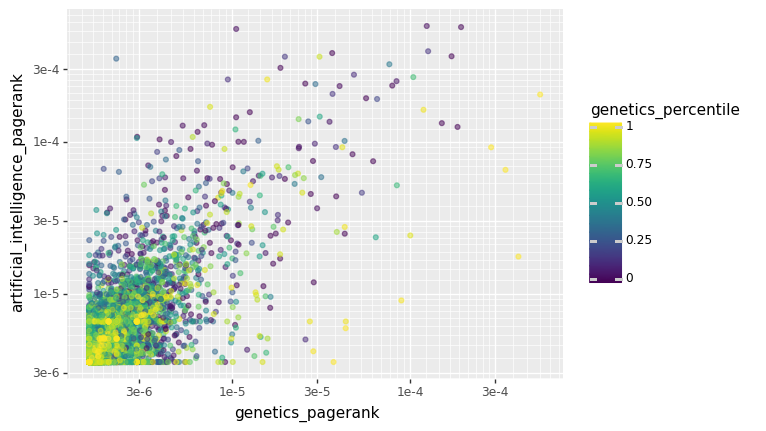

<ggplot: (8740059851143)>

In [50]:
plot = ggplot(merged_df, aes(x='genetics_pagerank', y='artificial_intelligence_pagerank', color='genetics_percentile'))
plot += geom_point(alpha=.5)
plot += scale_y_log10()
plot += scale_x_log10()
plot

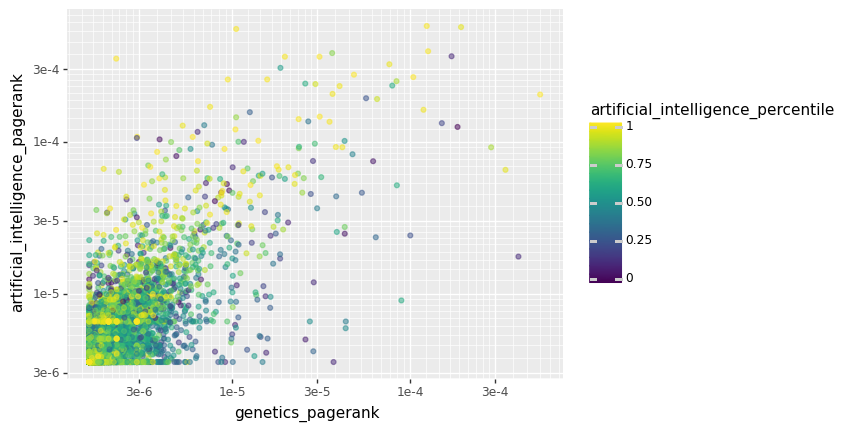

<ggplot: (8740090209914)>

In [51]:
plot = ggplot(merged_df, aes(x='genetics_pagerank', y='artificial_intelligence_pagerank', color='artificial_intelligence_percentile',))
plot += geom_point(alpha=.5)
plot += scale_y_log10()
plot += scale_x_log10()
plot

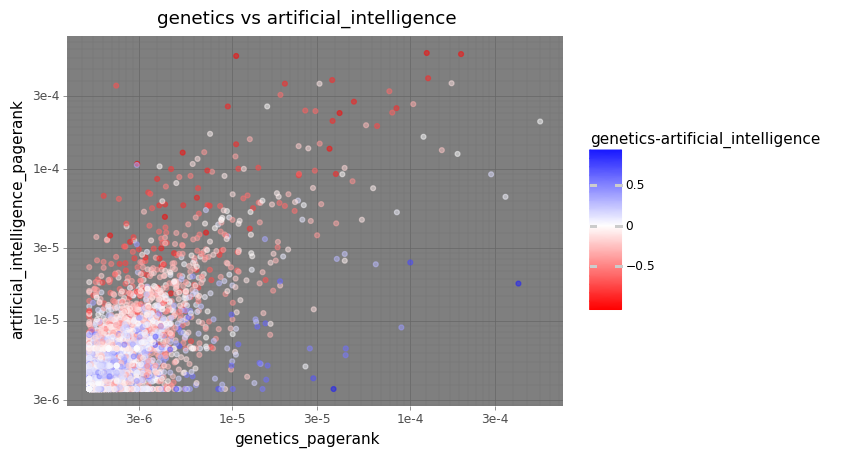

<ggplot: (8740081747941)>

In [52]:
plot = ggplot(merged_df, aes(x='genetics_pagerank', y='artificial_intelligence_pagerank', color='genetics-artificial_intelligence'))
plot += geom_point(alpha=.5)
plot += scale_y_log10()
plot += scale_x_log10()
plot += scale_color_gradient2(low='red', mid='white', high='blue')
plot += theme_dark()
plot += ggtitle('genetics vs artificial_intelligence')
plot

In [53]:
# Get papers that did surprisingly well in genetics but surprisingly poorly in artificial_intelligence
merged_df.sort_values(by='genetics-artificial_intelligence', ascending=False).head(5)

,doi,genetics_pagerank,genetics_percentile,artificial_intelligence_pagerank,artificial_intelligence_percentile,genetics-artificial_intelligence,pmid,pmcid,journal,journal_nlm_id,title,publication_date,authors
2816,10.1016/s0076-6879(99)03015-3,0.000037,1.00,0.000004,0.11,0.89,10349647,None,Methods Enzymol,0212271,Construction and analysis of arrayed cDNA libr...,1999,"[{'fore_name': 'M D', 'last_name': 'Clark', 'a..."
576,10.1093/bioinformatics/bti191,0.000405,1.00,0.000018,0.12,0.88,15608047,None,Bioinformatics,9808944,RAxML-III: a fast program for maximum likeliho...,2004-12-17,"[{'fore_name': 'A', 'last_name': 'Stamatakis',..."
2189,10.1093/bioinformatics/bts638,0.000003,0.85,0.000004,0.06,0.79,23110968,PMC3530916,Bioinformatics,9808944,Dragon TIS Spotter: an Arabidopsis-derived pre...,2012-10-30,"[{'fore_name': 'Arturo', 'last_name': 'Magana-..."
2575,10.3892/mmr.2017.6544,0.000002,0.96,0.000004,0.24,0.72,28487939,PMC5436207,Mol Med Rep,101475259,Identification of novel genes associated with ...,2017-05-03,"[{'fore_name': 'Feng', 'last_name': 'Gao', 'af..."
11,10.1074/mcp.m400031-mcp200,0.000100,0.95,0.000024,0.24,0.71,15238601,None,Mol Cell Proteomics,101125647,An improved model for prediction of retention ...,2004-07-06,"[{'fore_name': 'O V', 'last_name': 'Krokhin', ..."


In [54]:
merged_df.sort_values(by='genetics-artificial_intelligence', ascending=True).head(5)

,doi,genetics_pagerank,genetics_percentile,artificial_intelligence_pagerank,artificial_intelligence_percentile,genetics-artificial_intelligence,pmid,pmcid,journal,journal_nlm_id,title,publication_date,authors
671,10.1093/nar/gkt519,0.000003,0.00,0.000108,0.99,-0.99,23771147,PMC3692045,Nucleic Acids Res,0411011,kmer-SVM: a web server for identifying predict...,2013-06-14,"[{'fore_name': 'Christopher', 'last_name': 'Fl..."
387,10.1093/bioinformatics/btu277,0.000011,0.03,0.000553,0.99,-0.96,24931975,PMC4058935,Bioinformatics,9808944,Deep learning of the tissue-regulated splicing...,2014-06-15,"[{'fore_name': 'Michael K K', 'last_name': 'Le..."
258,10.1093/nar/gkt1140,0.000040,0.02,0.000233,0.98,-0.96,24253303,PMC3965022,Nucleic Acids Res,0411011,Activities at the Universal Protein Resource (...,2013-11-18,"[{'fore_name': None, 'last_name': None, 'affil..."
148,10.1093/nar/gku1179,0.000124,0.03,0.000579,0.99,-0.96,25428369,PMC4383973,Nucleic Acids Res,0411011,Gene Ontology Consortium: going forward.,2014-11-26,"[{'fore_name': None, 'last_name': None, 'affil..."
882,10.1021/acs.analchem.7b02566,0.000004,0.00,0.000048,0.96,-0.96,29125736,None,Anal Chem,0370536,pDeep: Predicting MS/MS Spectra of Peptides wi...,2017-11-21,"[{'fore_name': 'Xie-Xuan', 'last_name': 'Zhou'..."


### High genetics-ai:
- RAxML-III: a fast program for maximum likelihood-based inference of large phylogenetic trees 
- Construction and analysis of arrayed cDNA libraries
- Identification of novel genes associated with fracture healing in osteoporosis induced by Krm2 overexpression or Lrp5 deficiency
- Hierarchical Convolutional Neural Networks for Segmentation of Breast Tumors in MRI With Application to Radiogenomics
- Dragon TIS Spotter: an Arabidopsis-derived predictor of translation initiation sites in plants 

### Low genetics - ai:
- kmer-SVM: a web server for identifying predictive regulatory sequence features in genomic data sets 
- Hairpins in a Haystack: recognizing microRNA precursors in comparative genomics data 
- pDeep: Predicting MS/MS Spectra of Peptides with Deep Learning
- Hierarchical boosting: a machine-learning framework to detect and classify hard selective sweeps in human populations 
- Deep learning of the tissue-regulated splicing code 


### Comp bio vs microbio

In [55]:
merged_df = load_pair_headings('computational_biology', 'microbiology')

In [ ]:
fig = px.scatter(merged_df, x='computational_biology_pagerank', y='microbiology_pagerank', log_x=True, log_y=True, 
                 opacity=.5, color='computational_biology-microbiology', color_continuous_scale='RdBu', hover_data=['doi'],
                 title='Relative importance of papers in comp bio and genetics')
fig.show()

In [57]:
merged_df.sort_values(by='computational_biology-microbiology', ascending=True).head(5)

,doi,computational_biology_pagerank,computational_biology_percentile,microbiology_pagerank,microbiology_percentile,computational_biology-microbiology,pmid,pmcid,journal,journal_nlm_id,title,publication_date,authors
235,10.1016/j.mib.2010.02.001,0.000003,0.00,0.000027,0.98,-0.98,20226723,PMC2885540,Curr Opin Microbiol,9815056,Toward design-based engineering of industrial ...,2010-03-11,"[{'fore_name': 'Keith E J', 'last_name': 'Tyo'..."
205,10.1002/bit.22592,0.000006,0.02,0.000029,0.91,-0.89,19891008,None,Biotechnol Bioeng,7502021,Industrial systems biology.,2010-02-15,"[{'fore_name': 'José Manuel', 'last_name': 'Ot..."
258,10.1016/j.copbio.2011.11.021,0.000003,0.05,0.000017,0.94,-0.89,22169890,None,Curr Opin Biotechnol,9100492,Systems biology of yeast: enabling technology ...,2011-12-12,"[{'fore_name': 'Bouke', 'last_name': 'de Jong'..."
203,10.1111/j.1567-1364.2007.00302.x,0.000008,0.01,0.000030,0.87,-0.86,17727659,None,FEMS Yeast Res,101085384,Impact of systems biology on metabolic enginee...,2007-08-29,"[{'fore_name': 'Jens', 'last_name': 'Nielsen',..."
152,10.1128/aem.71.9.5544-5550.2005,0.000009,0.01,0.000154,0.80,-0.79,16151147,PMC1214672,Appl Environ Microbiol,7605801,Fungal community analysis by large-scale seque...,2005-09,"[{'fore_name': 'Heath E', 'last_name': 'O'Brie..."


In [58]:
merged_df.sort_values(by='computational_biology-microbiology', ascending=False).head(5)

,doi,computational_biology_pagerank,computational_biology_percentile,microbiology_pagerank,microbiology_percentile,computational_biology-microbiology,pmid,pmcid,journal,journal_nlm_id,title,publication_date,authors
13,10.1093/nar/gkn664,0.000146,0.98,0.000004,0.00,0.98,18836194,PMC2686606,Nucleic Acids Res,0411011,The Universal Protein Resource (UniProt) 2009.,2008-10-04,"[{'fore_name': None, 'last_name': None, 'affil..."
350,10.1128/jb.186.21.7029-7031.2004,0.000025,0.99,0.000006,0.05,0.94,15489416,PMC523225,J Bacteriol,2985120R,Phage taxonomy: we agree to disagree.,2004-11,"[{'fore_name': 'Daniel', 'last_name': 'Nelson'..."
217,10.1186/gb-2005-6-8-229,0.000054,0.94,0.000016,0.00,0.94,16086859,PMC1273625,Genome Biol,100960660,Metagenomics for studying unculturable microor...,2005-08-01,"[{'fore_name': 'Patrick D', 'last_name': 'Schl..."
127,10.1016/s0958-1669(03)00067-3,0.000056,0.95,0.000046,0.03,0.92,12849784,None,Curr Opin Biotechnol,9100492,Biotechnological prospects from metagenomics.,2003-06,"[{'fore_name': 'Patrick D', 'last_name': 'Schl..."
1063,10.1016/j.copbio.2004.02.006,0.000012,1.00,0.000004,0.16,0.84,15081044,None,Curr Opin Biotechnol,9100492,Post-genomics of lactic acid bacteria and othe...,2004-04,"[{'fore_name': 'Willem M', 'last_name': 'de Vo..."


### High CB - microbio
- The Universal Protein Resource (UniProt) 2009 
- Metagenomics for studying unculturable microorganisms: cutting the Gordian knot
- Phage Taxonomy: We Agree To Disagree
- Biotechnological prospects from metagenomics
- Pan-genome analysis of the emerging foodborne pathogen Cronobacterspp. suggests a species-level bidirectional divergence driven by niche adaptation

### High Microbio - CB
- Toward design-based engineering of industrial microbes
- Systems biology of yeast: enabling technology for development of cell factories for production of advanced biofuels
- Fungal Community Analysis by Large-Scale Sequencing of Environmental Samples
- Impact of systems biology on metabolic engineering of Saccharomyces cerevisiae 
- Industrial systems biology

### Top right (High pagerank in both)
- Community structure and metabolism through reconstruction of microbial genomes from the environment

### Comp bio vs medical informatics

In [59]:
merged_df = load_pair_headings('computational_biology', 'medical_informatics')
merged_df

,doi,computational_biology_pagerank,computational_biology_percentile,medical_informatics_pagerank,medical_informatics_percentile,computational_biology-medical_informatics,pmid,pmcid,journal,journal_nlm_id,title,publication_date,authors
0,10.1007/978-1-4939-3759-2_21,0.000002,1.00,0.000001,1.00,0.00,27424761,None,Methods Mol Biol,9214969,Sequence Search and Comparative Genomic Analys...,2016,"[{'fore_name': 'Lorenzo', 'last_name': 'Carret..."
1,10.1111/jocd.12528,0.000002,0.85,0.000001,1.00,-0.15,29797450,None,J Cosmet Dermatol,101130964,Prediction of skin anti-aging clinical benefit...,2018-05-23,"[{'fore_name': 'Sebastien', 'last_name': 'Hame..."
2,10.1016/s1474-4422(06)70578-6,0.000044,0.95,0.000030,0.96,-0.01,17052657,None,Lancet Neurol,101139309,Genome-wide genotyping in Parkinson's disease ...,2006-11,"[{'fore_name': 'Hon-Chung', 'last_name': 'Fung..."
3,10.1093/database/bat075,0.000005,0.07,0.000005,0.16,-0.09,24163125,PMC3808541,Database (Oxford),101517697,Tripal v1.1: a standards-based toolkit for con...,2013-10-25,"[{'fore_name': 'Lacey-Anne', 'last_name': 'San..."
4,10.1093/bioinformatics/bti1055,0.000016,0.78,0.000011,0.53,0.25,15961479,None,Bioinformatics,9808944,Kernels for small molecules and the prediction...,2005-06,"[{'fore_name': 'S Joshua', 'last_name': 'Swami..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28934,10.1002/prot.22836,0.000002,0.97,0.000002,0.32,0.65,20886466,None,Proteins,8700181,"Combined use of computational chemistry, NMR s...",2010-12,"[{'fore_name': 'Anna', 'last_name': 'Vulpetti'..."
28935,10.1186/gb-2006-7-8-r73,0.000016,0.04,0.000005,0.68,-0.64,16901351,PMC1779586,Genome Biol,100960660,UniPep--a database for human N-linked glycosit...,2006-08-10,"[{'fore_name': 'Hui', 'last_name': 'Zhang', 'a..."
28936,10.1177/1087057111400191,0.000005,0.48,0.000004,0.19,0.29,21471461,PMC3167204,J Biomol Screen,9612112,BioAssay ontology annotations facilitate cross...,2011-04,"[{'fore_name': 'Stephan C', 'last_name': 'Schü..."
28937,10.1186/1471-2105-15-267,0.000002,0.42,0.000002,0.17,0.25,25103881,PMC4137076,BMC Bioinformatics,100965194,A phenome-guided drug repositioning through a ...,2014-08-08,"[{'fore_name': 'Halil', 'last_name': 'Bisgin',..."


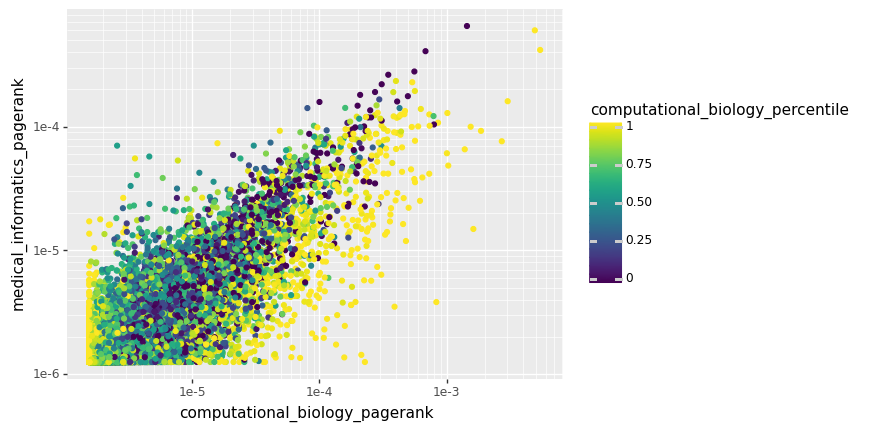

<ggplot: (8740059394451)>

In [60]:
plot = ggplot(merged_df, aes(x='computational_biology_pagerank', y='medical_informatics_pagerank', color='computational_biology_percentile'))
plot += geom_point()
plot += scale_y_log10()
plot += scale_x_log10()
plot

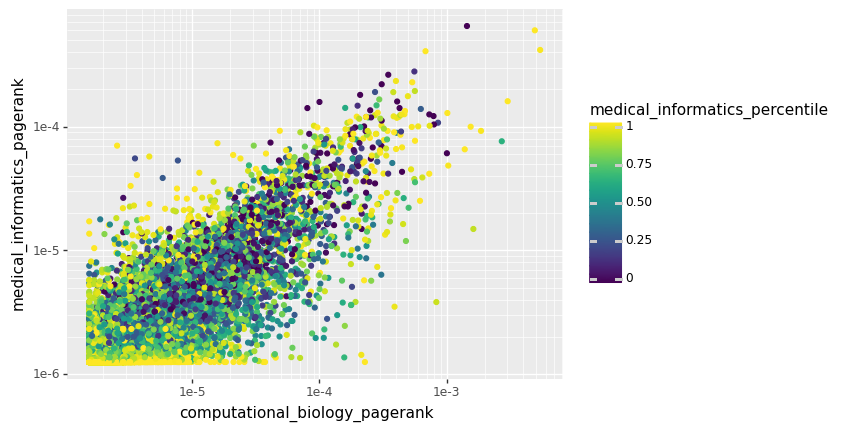

<ggplot: (8740099119318)>

In [61]:
plot = ggplot(merged_df, aes(x='computational_biology_pagerank', y='medical_informatics_pagerank', color='medical_informatics_percentile',))
plot += geom_point()
plot += scale_y_log10()
plot += scale_x_log10()
plot

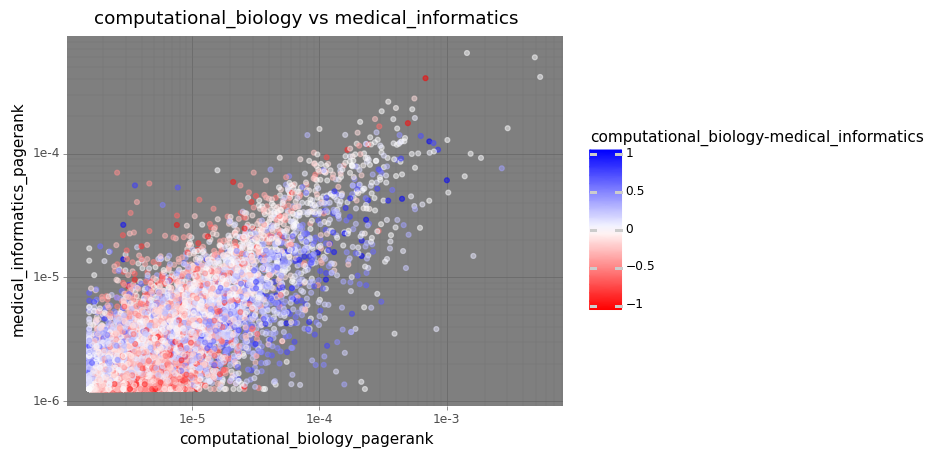

<ggplot: (8740087982714)>

In [62]:
plot = ggplot(merged_df, aes(x='computational_biology_pagerank', y='medical_informatics_pagerank', color='computational_biology-medical_informatics'))
plot += geom_point(alpha=.5)
plot += scale_y_log10()
plot += scale_x_log10()
plot += scale_color_gradient2(low='red', mid='white', high='blue')
plot += theme_dark()
plot += ggtitle('computational_biology vs medical_informatics')
plot

In [63]:
# Get papers that did surprisingly well in computational_biology but surprisingly poorly in medical_informatics
merged_df.sort_values(by='computational_biology-medical_informatics', ascending=False).head(5)

,doi,computational_biology_pagerank,computational_biology_percentile,medical_informatics_pagerank,medical_informatics_percentile,computational_biology-medical_informatics,pmid,pmcid,journal,journal_nlm_id,title,publication_date,authors
16650,10.1167/iovs.06-0996,0.000003,1.00,0.000014,0.00,1.00,17460289,PMC2739583,Invest Ophthalmol Vis Sci,7703701,Automated detection and differentiation of dru...,2007-05,"[{'fore_name': 'Meindert', 'last_name': 'Nieme..."
22286,10.1093/bioinformatics/14.10.846,0.000446,1.00,0.000043,0.00,1.00,9927713,None,Bioinformatics,9808944,Hidden Markov models for detecting remote prot...,1998,"[{'fore_name': 'K', 'last_name': 'Karplus', 'a..."
4367,10.1093/nar/gkg095,0.000730,1.00,0.000126,0.00,1.00,12520024,PMC165542,Nucleic Acids Res,0411011,The SWISS-PROT protein knowledgebase and its s...,2003-01-01,"[{'fore_name': 'Brigitte', 'last_name': 'Boeck..."
18113,10.1126/science.1075762,0.001004,0.99,0.000061,0.00,0.99,12471243,None,Science,0404511,The protein kinase complement of the human gen...,2002-12-06,"[{'fore_name': 'G', 'last_name': 'Manning', 'a..."
18313,10.1006/jmbi.2000.3741,0.000158,0.99,0.000023,0.01,0.98,10860755,None,J Mol Biol,2985088R,Enhanced genome annotation using structural pr...,2000-06-02,"[{'fore_name': 'L A', 'last_name': 'Kelley', '..."


In [64]:
merged_df.sort_values(by='computational_biology-medical_informatics', ascending=True).head(5)

,doi,computational_biology_pagerank,computational_biology_percentile,medical_informatics_pagerank,medical_informatics_percentile,computational_biology-medical_informatics,pmid,pmcid,journal,journal_nlm_id,title,publication_date,authors
24970,10.1016/j.copbio.2007.11.010,0.000005,0.0,0.000001,1.0,-1.0,18187318,None,Curr Opin Biotechnol,9100492,Antibody microarray analysis of directly label...,2008-01-09,"[{'fore_name': 'Christer', 'last_name': 'Wingr..."
17147,10.1038/nprot.2011.388,0.000011,0.0,0.000001,1.0,-1.0,22011652,PMC3516368,Nat Protoc,101284307,Proteomic analysis of formalin-fixed paraffin-...,2011-10-13,"[{'fore_name': 'Rita', 'last_name': 'Casadonte..."
19317,10.1038/nmeth.1923,0.000682,0.0,0.000407,1.0,-1.0,22388286,PMC3322381,Nat Methods,101215604,Fast gapped-read alignment with Bowtie 2.,2012-03-04,"[{'fore_name': 'Ben', 'last_name': 'Langmead',..."
12622,10.1021/acs.analchem.7b01098,0.000004,0.0,0.000001,1.0,-1.0,28505421,None,Anal Chem,0370536,Development of High-Performance Chemical Isoto...,2017-05-25,"[{'fore_name': 'Shuang', 'last_name': 'Zhao', ..."
20682,10.1097/jom.0000000000000773,0.000003,0.0,0.000001,1.0,-1.0,27501105,PMC4978147,J Occup Environ Med,9504688,High-Resolution Metabolomics Assessment of Mil...,2016-08,"[{'fore_name': 'Ken H', 'last_name': 'Liu', 'a..."


In [65]:
merged_df['percentile_sum'] = merged_df['computational_biology_percentile'] + merged_df['medical_informatics_percentile']
merged_df.sort_values(by='percentile_sum', ascending=False).head(5)

,doi,computational_biology_pagerank,computational_biology_percentile,medical_informatics_pagerank,medical_informatics_percentile,computational_biology-medical_informatics,pmid,pmcid,journal,journal_nlm_id,title,publication_date,authors,percentile_sum
0,10.1007/978-1-4939-3759-2_21,0.000002,1.0,0.000001,1.0,0.0,27424761,None,Methods Mol Biol,9214969,Sequence Search and Comparative Genomic Analys...,2016,"[{'fore_name': 'Lorenzo', 'last_name': 'Carret...",2.0
14470,10.1534/g3.119.400850,0.000002,1.0,0.000001,1.0,0.0,31843805,PMC7003081,G3 (Bethesda),101566598,Wnt Signaling Drives Ectopic Gene Expression a...,2020-02-06,"[{'fore_name': 'Jerrin R', 'last_name': 'Cheri...",2.0
19223,10.1155/2021/1093702,0.000002,1.0,0.000001,1.0,0.0,33564675,PMC7867452,Biomed Res Int,101600173,Microarray Data Mining and Preliminary Bioinfo...,2021-01-30,"[{'fore_name': 'Zhe', 'last_name': 'Yu', 'affi...",2.0
24487,10.3390/ijms222212419,0.000002,1.0,0.000001,1.0,0.0,34830301,PMC8620086,Int J Mol Sci,101092791,"Hypoglycemia, Vascular Disease and Cognitive D...",2021-11-17,"[{'fore_name': 'Olga V', 'last_name': 'Saik', ...",2.0
24495,10.1038/s41598-019-48806-w,0.000002,1.0,0.000001,1.0,0.0,31444376,PMC6707231,Sci Rep,101563288,Comparative transcriptome and metabolite profi...,2019-08-23,"[{'fore_name': 'Wenjin', 'last_name': 'Lin', '...",2.0


### High CB
- The Biomedical Data Translator Program: Conception, Culture, and Community
- Mean mass-specific metabolic rates are strikingly similar across life's major domains: Evidence for life's metabolic optimum
- Cross validation issues in multiobjective clustering
- Simultaneous Segmentation of Leukocyte and Erythrocyte in Microscopic Images Using a Marker-Controlled Watershed Algorithm
- A tiered approach to comparative genomics 

### High Medical informatics
- Human urinary biomarkers of dioxin exposure: Analysis by metabolomics and biologically driven data dimensionality reduction
- High-Resolution Metabolomics Assessment of Military Personnel Evaluating Analytical Strategies for Chemical Detection
- Development of High-Performance Chemical Isotope Labeling LC–MS for Profiling the Carbonyl Submetabolome
- Differential Carbonylation of Proteins as a Function of in vivo Oxidative Stress
- Fast gapped-read alignment with Bowtie 2

<AxesSubplot:>

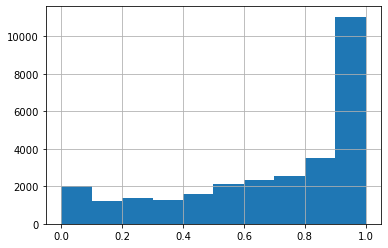

In [66]:
merged_df['computational_biology_percentile'].hist()

<AxesSubplot:>

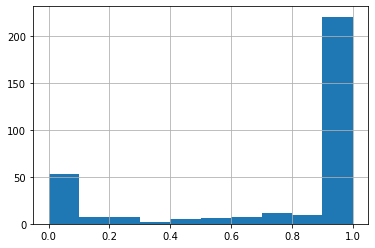

In [67]:
merged_df[merged_df['computational_biology_pagerank'] > 1e-4]['computational_biology_percentile'].hist()

<AxesSubplot:>

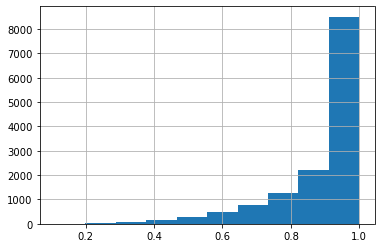

In [68]:
merged_df[merged_df['computational_biology_pagerank'] < 2e-6]['computational_biology_percentile'].hist()

In [69]:
merged_df['journal'].value_counts() > 100

Nucleic Acids Res            True
BMC Bioinformatics           True
Bioinformatics               True
Methods Mol Biol             True
PLoS One                     True
                            ...  
J Periodontal Res           False
Autoimmun Rev               False
Injury                      False
IEEE Trans Image Process    False
J Diabetes Sci Technol      False
Name: journal, Length: 1689, dtype: bool

In [70]:
journal_groups = merged_df.groupby('journal')
medians = journal_groups.median()
sizes = journal_groups.size()
medians[sizes > 100]

,computational_biology_pagerank,computational_biology_percentile,medical_informatics_pagerank,medical_informatics_percentile,computational_biology-medical_informatics,percentile_sum
journal,,,,,,
Adv Exp Med Biol,0.000002,0.960,0.000001,1.000,0.000,1.850
Anal Chem,0.000004,0.220,0.000002,0.670,-0.285,0.920
BMC Bioinformatics,0.000002,0.720,0.000002,0.750,0.000,1.450
BMC Genomics,0.000002,0.760,0.000001,0.890,-0.075,1.630
BMC Syst Biol,0.000002,0.685,0.000001,0.810,-0.080,1.485
Bioinformatics,0.000003,0.660,0.000002,0.690,-0.010,1.310
Biomed Res Int,0.000002,1.000,0.000001,1.000,0.000,2.000
Brief Bioinform,0.000002,0.810,0.000002,0.830,0.000,1.590
Comput Biol Chem,0.000002,0.905,0.000001,0.900,0.000,1.815


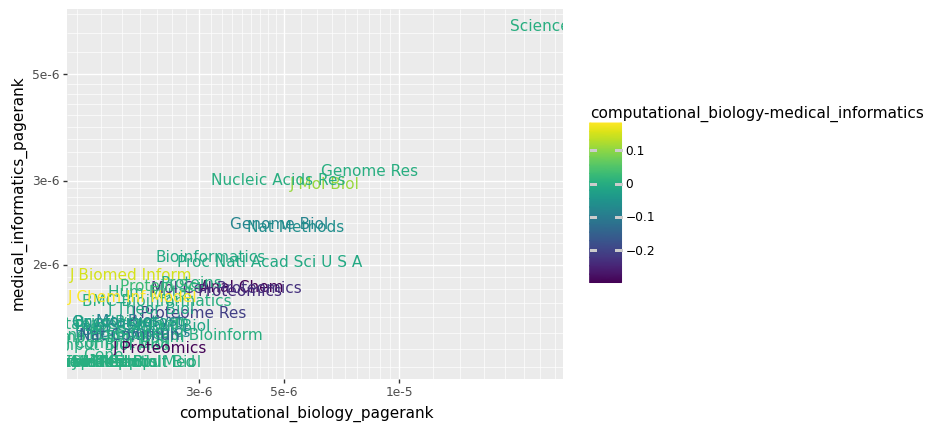

<ggplot: (8740034072201)>

In [71]:
medians['journal_title'] = medians.index
plot = ggplot(medians[sizes > 100], aes(x='computational_biology_pagerank', 
                                        y='medical_informatics_pagerank', 
                                        color='computational_biology-medical_informatics'))
plot += geom_text(aes(label='journal_title'))
plot += scale_y_log10()
plot += scale_x_log10()
plot

In [ ]:
fig = px.scatter(medians[sizes > 100],x='computational_biology_pagerank', 
                                      y='medical_informatics_pagerank', log_x=True, log_y=True, 
                                      color='computational_biology-medical_informatics', title='Journals',
                                      hover_data = ['journal_title'])
fig

In [73]:
merged_df = load_pair_headings('computational_biology', 'genetics')

In [74]:
journal_groups = merged_df.groupby('journal')
medians = journal_groups.median()
sizes = journal_groups.size()

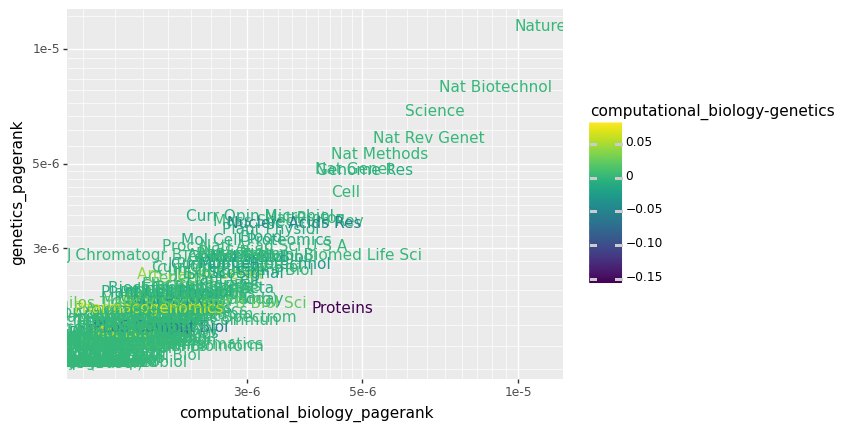

<ggplot: (8740086558856)>

In [75]:
medians['journal_title'] = medians.index
plot = ggplot(medians[sizes > 100], aes(x='computational_biology_pagerank', 
                                        y='genetics_pagerank', 
                                        color='computational_biology-genetics'))
plot += geom_text(aes(label='journal_title'))
plot += scale_y_log10()
plot += scale_x_log10()
plot

In [ ]:
fig = px.scatter(medians[sizes > 100],x='computational_biology_pagerank', 
                                      y='genetics_pagerank', log_x=True, log_y=True, 
                                      color='computational_biology-genetics', title='Journals',
                                      hover_data = ['journal_title'])
fig

### Plot and save results

In [77]:
headings = ["artificial_intelligence", "computational_biology", 
            "ecology", "genetics", "medical_informatics", "microbiology"]

for heading1, heading2 in tqdm(itertools.combinations(headings, 2), total=15):

    merged_df = load_pair_headings(heading1, heading2)

    journal_groups = merged_df.groupby('journal')
    medians = journal_groups.median()
    sizes = journal_groups.size()

    medians['journal_title'] = medians.index
    plot = ggplot(medians[sizes > 100], aes(x=f'{heading1}_pagerank', 
                                            y=f'{heading2}_pagerank', 
                                            color=f'{heading1}-{heading2}'))
    plot += geom_text(aes(label='journal_title'))
    plot += scale_y_log10()
    plot += scale_x_log10()
    plot += ggtitle(f'{heading1} vs {heading2} journals')
    
    plot.save(f'../output/figures/{heading1}-{heading2}-journals.png')
    
    plot = ggplot(merged_df, aes(x=f'{heading1}_pagerank', y=f'{heading2}_pagerank', color=f'{heading1}-{heading2}'))
    plot += geom_point(alpha=.5)
    plot += scale_y_log10()
    plot += scale_x_log10()
    plot += scale_color_gradient2(low='red', mid='white', high='blue')
    plot += theme_dark()
    plot += ggtitle(f'{heading1} vs {heading2} papers')
    plot.save(f'../output/figures/{heading1}-{heading2}-papers.png')

  0%|                                                                                          | 0/15 [00:00<?, ?it/s]/home/heil/anaconda3/envs/indices/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning:

Saving 6.4 x 4.8 in image.

/home/heil/anaconda3/envs/indices/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning:

Filename: ../output/figures/artificial_intelligence-computational_biology-journals.png

/home/heil/anaconda3/envs/indices/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning:

Saving 6.4 x 4.8 in image.

/home/heil/anaconda3/envs/indices/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning:

Filename: ../output/figures/artificial_intelligence-computational_biology-papers.png

  7%|█████▍                                                                            | 1/15 [00:26<06:11, 26.56s/it]/home/heil/anaconda3/envs/indices/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning:

Saving 6.

 73%|███████████████████████████████████████████████████████████▍                     | 11/15 [04:25<01:32, 23.20s/it]/home/heil/anaconda3/envs/indices/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning:

Saving 6.4 x 4.8 in image.

/home/heil/anaconda3/envs/indices/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning:

Filename: ../output/figures/ecology-microbiology-journals.png

/home/heil/anaconda3/envs/indices/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning:

Saving 6.4 x 4.8 in image.

/home/heil/anaconda3/envs/indices/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning:

Filename: ../output/figures/ecology-microbiology-papers.png

 80%|████████████████████████████████████████████████████████████████▊                | 12/15 [04:34<00:56, 18.84s/it]/home/heil/anaconda3/envs/indices/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning:

Saving 6.4 x 4.8 in image.

/home/heil/anaconda3/envs/indic